# Week5 ex4

# 필요 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
data = loadmat("./ex4data1.mat")
X = data['X']
y = data['y']

In [3]:
data2 = loadmat("./ex4weights.mat")
Theta1 = data2['Theta1']
Theta2 = data2['Theta2']

In [4]:
def draw_image(img):
    plt.imshow(img.reshape(20, 20).T, cmap='gray_r')
    plt.axis('off')

# 1. 데이터 사이즈 체크

In [5]:
print(X.shape)
print(y.shape)
print(Theta1.shape)
print(Theta2.shape)

(5000, 400)
(5000, 1)
(25, 401)
(10, 26)


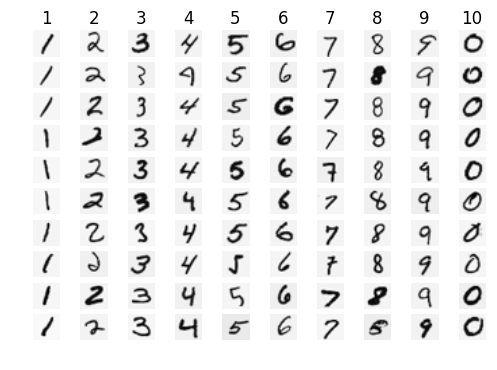

In [6]:
num_of_rows = 10
idx = 1
for row in range(num_of_rows):
    for column in np.unique(y):
        plt.subplot(num_of_rows, len(np.unique(y)), idx)  
        if row==0:
            plt.title("{}".format(column))
        min_set = X[(y==column).flatten()]
        choice = np.random.randint(low=0, high=min_set.shape[0], size=1)        
        draw_image(min_set[choice])
        idx += 1

# 2. Helper Functions

In [7]:
def bias_trick(X):
    """
    Add bias term. [X] --> [1, X]
    """
    return np.append(np.ones(shape=(X.shape[0], 1)), X, axis=1)


def sigmoid(z):
    """
    sigmoid activator function
    """
    return 1.0 / (1 + np.exp(-z))


def predict(Theta1, Theta2, X):
    """
    Predict y given Theta1, Theta2, X
    """
    z2 = bias_trick(X).dot(Theta1.T)
    a2 = sigmoid(z2)
    
    z3 = bias_trick(a2).dot(Theta2.T)
    a3 = sigmoid(z3)
    
    y_pred = np.argmax(a3, axis=1) + 1
    
    return y_pred

def flatten_out(Theta1, Theta2):
    """
    Returns np.append(Theta1.flatten(), Theta2.flatten())    
    """
    return np.append(Theta1.flatten(), Theta2.flatten())

def separate_grad(nn_params, input_layer_size, hidden_layer_size, num_labels):
    Theta1 = nn_params[0: hidden_layer_size * (input_layer_size+1)].reshape(hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[hidden_layer_size * (input_layer_size+1): ].reshape(num_labels, hidden_layer_size + 1)
        
    return Theta1, Theta2

def print_accuracy(y_pred, y):
    print("""
Accuracy: {:.3%}    
    """.format(np.mean(y_pred.flatten() == y.flatten())))

# 3. 시작

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K -y_k^{(i)}\cdot \log a^{(3)}_k - (1 - y_k^{(i)}) \cdot \log( 1 - a^{(3)}_k) $$

In [8]:
def randInitializeWeight(L_in, L_out, EPSILON=0.12):
    """
    Initialize the weight W 
    ========================
    L_in : number of incoming connections
    L_out: number of outgoing connections    
    
    """
    W = np.zeros(shape=(L_out, L_in + 1))
    W += np.random.randn(L_out, L_in + 1) * 2 * EPSILON - EPSILON
    return W

In [9]:
def sigmoidGradient(z):
    """
    Returns the gradient descent of the sigmoid function.    
    """
    z = np.array(z)
    g = sigmoid(z) * (1 - sigmoid(z))
    return g

In [10]:
def computeNumericalGradient(J, theta):
    """
    Computes the gradient descent using numerical estimate
    ======================================================    
    J    : A cost function. J(theta) should give the value
    Theta: Flatten vector [Theta1, Theta2]
    ======================================================
    Returns numgrad
    numgrad(i) is derivative of J with respect to theta
    """
    numgrad = np.zeros_like(theta)
    for i in range(len(theta)):
        e = np.zeros_like(theta)
        e[i] = 1e-5
        cost1 = J(theta - e)
        cost2 = J(theta + e)
        
        numgrad[i] = (cost2 - cost1) / (e[i] * 2)
        
    return numgrad

In [11]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmda, quick=0):
    """
    Calculates J and gradient descent
    ======================================
    nn_params        : 
    
        Theta1 = nn_params[0: hidden_layer_size * input_layer_size]
            size = (h, d + 1)
        Theta2 = nn_params[hidden_layer_size * input_layer_size: ]
            size = (r, h + 1)
    
    input_layer_size : input nodes (= d)
    hidden_layer_size: hidden layer nodes (= h)
    num_labels       : num of labels (= r)
    X                : X (m, d)
    y                : y (m, 1)
    lmda             : regularization term. If lmda==0: no regularization;
    =======================================
    Returns
        J            : Loss (float)
        grad         : np.append(Theta1.flatten(), Theta2.flatten()) (np.array)
                           
    """

    Theta1, Theta2 = separate_grad(nn_params, input_layer_size, hidden_layer_size, num_labels)
    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros_like(Theta1) # (h, d + 1)
    Theta2_grad = np.zeros_like(Theta2) # (r, h + 1)
    
    """
    1. Define Cost Function
    """
    X = bias_trick(X)          # (m, d + 1)
    
    z2 = X.dot(Theta1.T)       # (m, d + 1) * (d + 1, h) = (m, h)
    a2 = sigmoid(z2)           # (m, h)
    
    a2_bias = bias_trick(a2)   # (m, h) -> (m, h + 1)
    z3 = a2_bias.dot(Theta2.T) # (m, h + 1) * (h + 1, r) = (m, r)
    a3 = sigmoid(z3)           # (m, r)
    
    y_matrix = np.zeros_like(a3) # (m, r)
    y_matrix[range(y_matrix.shape[0]), y.flatten()-1] = 1
       

    
    J = -1 * y_matrix * np.log(a3) - (1 - y_matrix) * np.log(1 - a3) # (m, r)
    J = np.sum(J)/m
    
    J += np.sum(np.square(Theta1[:, 1:]))*lmda/(2*m) + np.sum(np.square(Theta2[:, 1:]))*lmda/(2*m)
    
    if quick:
        return J
    
    
    """
    2. Implement backpropagation
    """    
    Theta2_grad = (a3 - y_matrix).T.dot(a2_bias)
    
    Theta1_grad = (a3 - y_matrix).dot(Theta2[:, 1:]) * sigmoidGradient(z2)
    Theta1_grad = Theta1_grad.T.dot(X)
    
    Theta1_grad /= m
    Theta2_grad /= m
    
           
    """
    3. Implement regularization
    """
    tmp = Theta1
    tmp[:, 0] = 0
    Theta1_grad += tmp * lmda / m
    
    tmp = Theta2
    tmp[:, 0] = 0
    Theta2_grad += tmp * lmda / m    
    ############################################
    grad = flatten_out(Theta1_grad, Theta2_grad)
    
    return J, grad

# Test Function

In [33]:
IN = 400
HIDDEN = 2
OUT = 10

T1 = randInitializeWeight(IN, HIDDEN)
T2 = randInitializeWeight(HIDDEN, OUT)
nn = flatten_out(T1,T2)
f = lambda th: nnCostFunction(th, IN, HIDDEN, OUT, X, y, 0, quick=1)

for i in range(10):
    grad_num = computeNumericalGradient(f, nn)
    J, grad_anal = nnCostFunction(nn, IN, HIDDEN, OUT, X, y, lmda=0)
    print("diff: {}".format(np.sum(np.abs(grad_num-grad_anal))))
    
    nn = nn - 0.01 * grad_anal

diff: 3.209299032817658e-08
diff: 3.67472914780575e-08
diff: 3.5593287018751366e-08
diff: 3.5085492776003965e-08
diff: 4.181155240371087e-08
diff: 3.336188337139886e-08
diff: 3.5950020832643486e-08
diff: 3.598379847327694e-08
diff: 3.4204040182823e-08
diff: 3.8726915281147834e-08


In [23]:
a = nnCostFunction(flatten_out(Theta1, Theta2), 400, 25, 10, X, y, 0)[0]
b = nnCostFunction(flatten_out(Theta1, Theta2), 400, 25, 10, X, y, 1)[0]
print("J(theta) without regularization test passed? {}".format(np.abs(a - 0.287629) < 1e-6))
print("J(theta) with regularization test passed? {}".format(np.abs(b - 0.383770) < 1e-6))

J(theta) without regularization test passed? True
J(theta) with regularization test passed? True


In [44]:
IN = 400
HIDDEN = 25
OUT = 10
ALPHA = 0.5
LMDA = 1


T1 = randInitializeWeight(IN, HIDDEN)
T2 = randInitializeWeight(HIDDEN, OUT)
nn = flatten_out(T1,T2)

beta1 = 0.99
beta2 = 0.95
m = 0
v = 0

J_history = []
for i in range(3000):    
    J, grad_anal = nnCostFunction(nn, IN, HIDDEN, OUT, X, y, lmda=LMDA)    
    if i % 100 == 0:
        print(J)
    J_history.append(J)
    
    m = beta1*m + (1-beta1)*grad_anal
    v = beta2*v + (1-beta2)*(grad_anal**2)
    nn += - ALPHA * m / (np.sqrt(v) + 1e-8)


    

6.37941685467
2.99326184859
1.57805020241
1.10323236971
0.786480676066
0.571936079393
0.460784016126
0.389180912173
0.355895279984
0.336766910146
0.325649442478
0.317956335424
0.315719112616
0.313006105853
0.311228583383
0.312501268176
0.311460427914
0.312822892616
0.310541127984
0.31018505307
0.310806630874
0.310393036608
0.310762961217
0.310473756401
0.310559514733
0.310716135049
0.309855049019
0.310679028035
0.310309072298
0.310002105688


In [45]:
Theta1, Theta2 = separate_grad(nn, IN, HIDDEN, OUT)
y_pred = predict(Theta1, Theta2, X)
print_accuracy(y_pred, y)


Accuracy: 99.660%    
    
